# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

# Problem 1 and 2)
We analyze the Microsoft stock's log return data during the past 5 years.

In [1]:
#package import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set_style('darkgrid')

1)

/tmp/ipython-input-2-597886973.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download('MSFT', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed


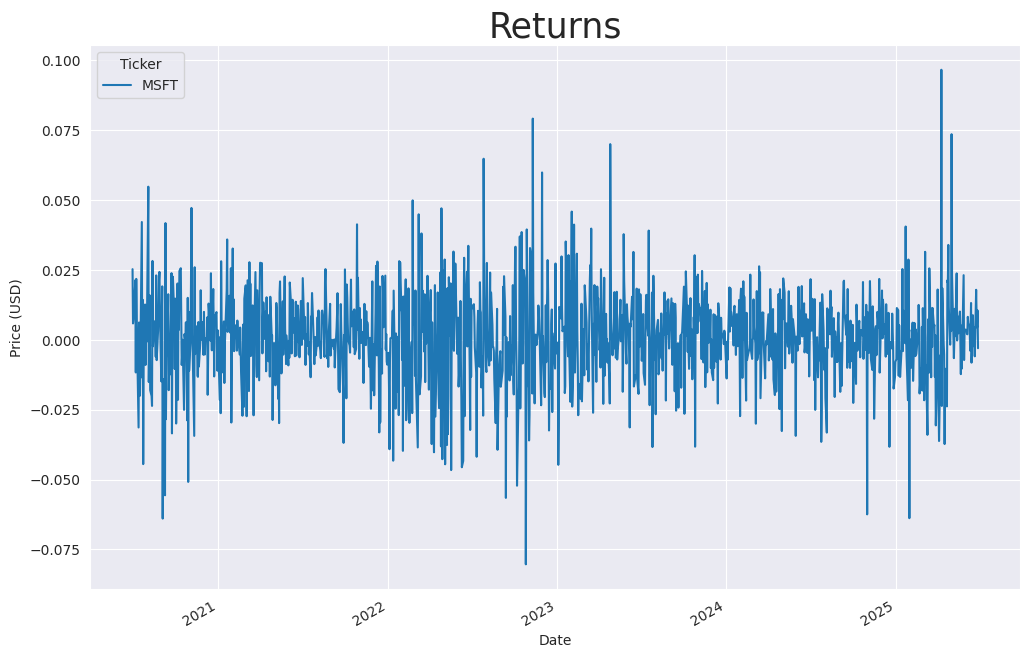

In [2]:
### Load data from yfinance and plot the daily log returns ###

start_date = dt.datetime.today() - dt.timedelta(days = 365*5) # Download 5 years of data
end_date = dt.datetime.today()

stock = yf.download('MSFT', start = start_date, end = end_date)

daily_log_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_log_returns = daily_log_returns.dropna()

daily_log_returns.plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

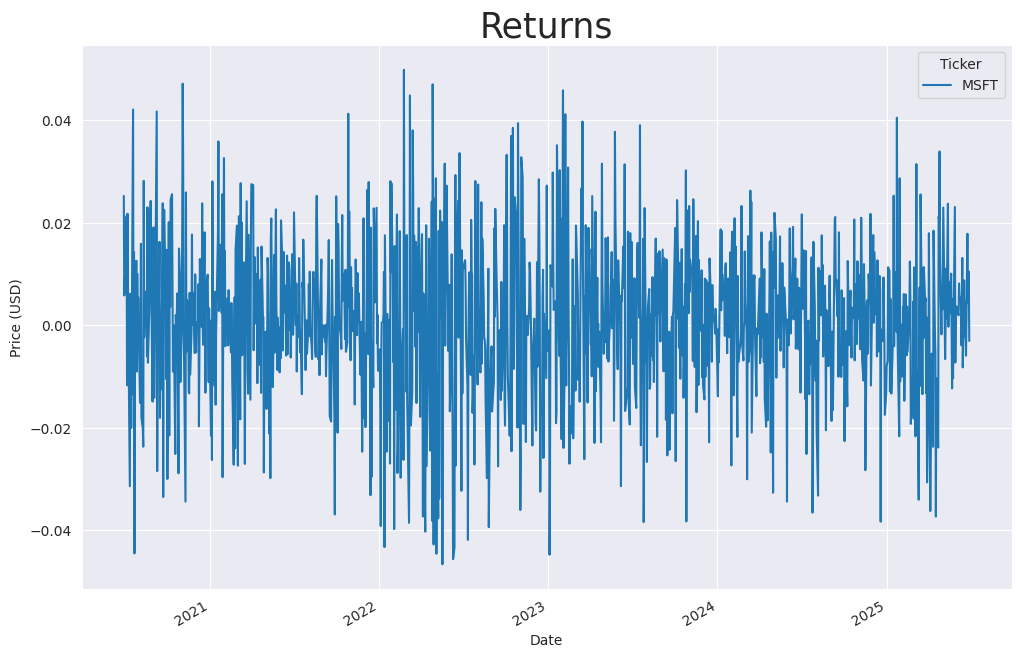

In [3]:
### Remove the extreme cases and plot again ###

# Filter the DataFrame to remove rows where the 'MSFT' column is outside of 3 standard deviations from the mean
new_daily_log_returns = daily_log_returns[daily_log_returns['MSFT'].between(daily_log_returns['MSFT'].mean() - 3 * daily_log_returns['MSFT'].std(), daily_log_returns['MSFT'].mean() + 3 * daily_log_returns['MSFT'].std())]
new_daily_log_returns = new_daily_log_returns.dropna()

new_daily_log_returns.plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

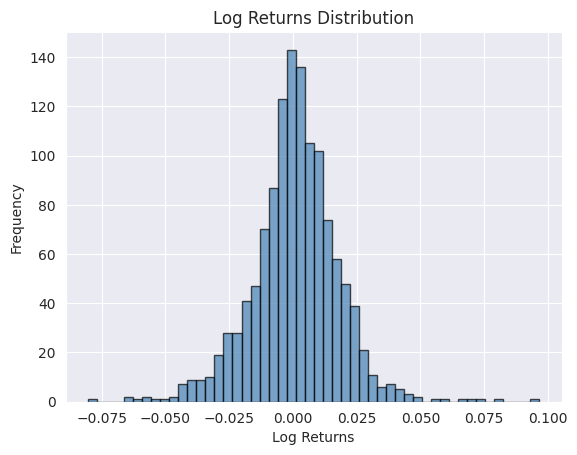

In [4]:
### Plot the frequency of the log returns using histogram ###

plt.hist(daily_log_returns['MSFT'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Log Returns Distribution')
plt.grid(True)
plt.show()

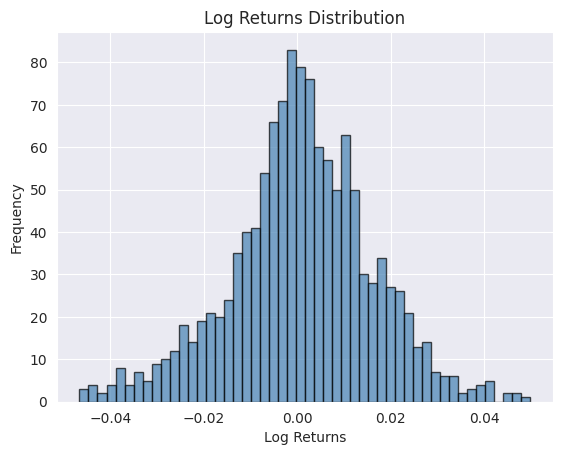

In [5]:
### Plot the frequency of the log returns using histogram ###

plt.hist(new_daily_log_returns['MSFT'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.title('Log Returns Distribution')
plt.grid(True)
plt.show()

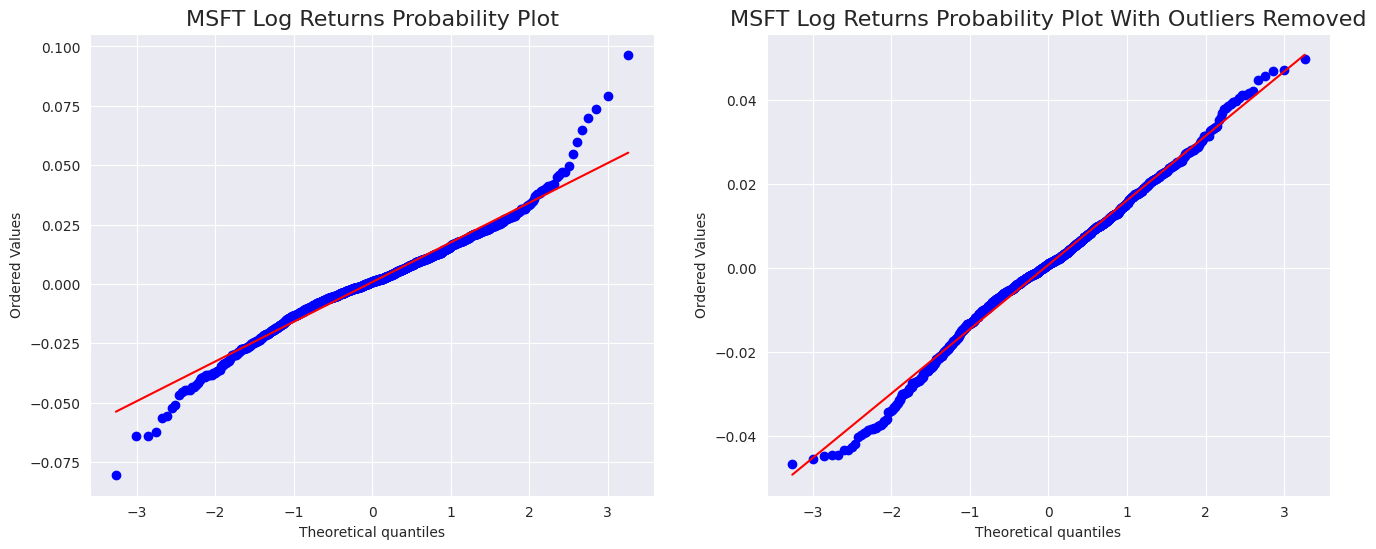

In [6]:
### Plot and compare the normality tests for daily log returns of MSFT ###

# Create 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot MSFT log returns
stats.probplot(daily_log_returns['MSFT'], dist="norm", plot=axes[0])
axes[0].set_title("MSFT Log Returns Probability Plot", fontsize=16)
axes[0].grid(True)

# Plot MSFT log returns with extreme cases removed
stats.probplot(new_daily_log_returns['MSFT'], dist="norm", plot=axes[1])
axes[1].set_title("MSFT Log Returns Probability Plot With Outliers Removed", fontsize=16)
axes[1].grid(True)

plt.show()

In [7]:
### Collect p-values of normality tests ###
p_msft=stats.normaltest(daily_log_returns['MSFT'])[1]
p_new_msft = stats.normaltest(new_daily_log_returns['MSFT'])[1]


### Print evidence/non-evidence of normality ###
print(f"MSFT log return distribution: p-value = {p_msft:.4f}")
if p_msft < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

print('--'*40)
print('--'*40)


print(f"MSFT log return distribution: p-value = {p_new_msft:.4f}")
if p_new_msft < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

MSFT log return distribution: p-value = 0.0000
→ Statistically significant evidence that the data is NOT normally distributed.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
MSFT log return distribution: p-value = 0.0016
→ Statistically significant evidence that the data is NOT normally distributed.


# Problem 4)

In [15]:
from scipy.optimize import minimize

### Load data for each stock from yfinance ###
tickers = ['MSFT', 'GOOGL', 'AMZN', 'TSLA', 'F']

#yf.Ticker(tickers[5]).info

start_date = dt.datetime.today() - dt.timedelta(days = 1*365)
end_date = dt.datetime.today() - dt.timedelta(days = 0*365)

stock = yf.download(tickers, start = start_date, end =end_date)

### Setting parameters and constants ###

#Calculate the covariance matrix
daily_returns = np.log(stock['Close']/stock['Close'].shift(1))
daily_returns = daily_returns.dropna()
covariance_matrix = 252*((daily_returns).cov())


#Create a dictionary of standard deviations of daily return
#Normalize the standard deviation for yearly by multiplying by sqrt(#trading days in year ~ 252)
annualized_volatility = {ticker: np.std(daily_returns[ticker])*np.sqrt(252) for ticker in tickers}



# Number of assets
n_assets = len(tickers)

# Define an initial guess for asset weights (n=5 in our case)
initial_weights = np.array([1/n_assets] * n_assets)

# Define weight constraints
#Sum of weights equals 1
#Allocate at least 5% of capital into each index in stock_symbols
#Do not allocate more than 35% of capital into each index in stock_symbol

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
               {'type': 'ineq', 'fun': lambda weights: min(weights)-.05},
              {'type': 'ineq', 'fun': lambda weights: .35-max(weights)})

### Define functions ###

def annual_log_return(weights):
    portfolio_value = (stock['Close'] * weights).sum(axis=1)
    daily_log_returns = np.log(portfolio_value / portfolio_value.shift(1))
    annualized_log_return = np.sum(daily_log_returns.dropna())
    return annualized_log_return

def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_std_dev

def objective_1(weights):
    return -(annual_log_return(weights) - 7.0*portfolio_volatility(weights)) # lambda = 7

def objective_2(weights):
    return -(annual_log_return(weights) - 1.0*portfolio_volatility(weights)) # lambda = 1


result_1 = minimize(objective_1, initial_weights, constraints=constraints)
result_2 = minimize(objective_2, initial_weights, constraints=constraints)


# Optimal asset weights

optimal_weights_1 = result_1.x
optimal_weights_2 = result_2.x

portfolio_value_1 = (stock['Close'] * optimal_weights_1).sum(axis=1)
daily_log_returns_1 = np.log(portfolio_value_1 / portfolio_value_1.shift(1))
daily_log_returns_1 = daily_log_returns_1.dropna()

portfolio_value_2 = (stock['Close'] * optimal_weights_2).sum(axis=1)
daily_log_returns_2 = np.log(portfolio_value_2 / portfolio_value_2.shift(1))
daily_log_returns_2 = daily_log_returns_2.dropna()

### Collect p-values of normality tests ###
p_1 = stats.normaltest(daily_log_returns_1.dropna())[1]
p_2 = stats.normaltest(daily_log_returns_2.dropna())[1]


### Print evidence/non-evidence of normality ###
print(f"Project 1 log return distribution (Objective 1): p-value = {p_1 :.4f}")
if p_1 < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

print('--'*40)
print('--'*40)


print(f"Project 1 log return distribution (Objective 2): p-value = {p_2:.4f}")
if p_2 < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

/tmp/ipython-input-15-3137823633.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(tickers, start = start_date, end =end_date)
[*********************100%***********************]  5 of 5 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Project 1 log return distribution (Objective 1): p-value = 0.0000
→ Statistically significant evidence that the data is NOT normally distributed.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Project 1 log return distribution (Objective 2): p-value = 0.0000
→ Statistically significant evidence that the data is NOT normally distributed.


# Problem 5)


In [ ]:
### Download historical data for the selected tickers ###

tickers = ['MSFT', 'GOOGL', 'AMZN', 'AAPL','TSLA','F', 'GM']
start_date = dt.datetime.today() - dt.timedelta(days = 365*5) # Download 5 years of data
end_date = dt.datetime.today()

historical_data = yf.download(tickers, start = start_date, end = end_date)

/tmp/ipython-input-35-957291146.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  historical_data = yf.download(tickers, start = start_date, end = end_date)
[*********************100%***********************]  7 of 7 completed


In [ ]:
### Calculate daily log returns for each stock ###

log_returns = np.log(historical_data['Close'] / historical_data['Close'].shift(1))
log_returns = log_returns.dropna()

In [ ]:
### Generate yearly time periods for analysis within the range of log_returns data ###

min_date = log_returns.index.min()
max_date = log_returns.index.max()

analysis_periods = []
current_start_year = min_date.year
while dt.datetime(current_start_year, 1, 1) <= max_date:
    start_date = dt.datetime(current_start_year, 1, 1)
    end_date = dt.datetime(current_start_year, 12, 31)

    if end_date > max_date:
        end_date = max_date

    if start_date <= max_date:
        analysis_periods.append((max(start_date, min_date), end_date))
    current_start_year += 1

print("Analysis Periods (Yearly):")
for start, end in analysis_periods:
    print(f"Start: {start.strftime('%Y-%m-%d')}, End: {end.strftime('%Y-%m-%d')}")

Analysis Periods (Yearly):
Start: 2020-06-30, End: 2020-12-31
Start: 2021-01-01, End: 2021-12-31
Start: 2022-01-01, End: 2022-12-31
Start: 2023-01-01, End: 2023-12-31
Start: 2024-01-01, End: 2024-12-31
Start: 2025-01-01, End: 2025-06-27


In [ ]:
### Analyze and present the results ###
###  ###

# Store normality results for each period and stock
period_normality_results = {}

# Iterate through each defined time period
for start_date, end_date in analysis_periods:
    period_key = f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"
    period_normality_results[period_key] = {}

    # Filter log returns for the current time period
    log_returns_period = log_returns.loc[start_date:end_date]

    # Perform normality test for each stock in the current period
    for ticker in log_returns_period.columns:
        p_value = stats.normaltest(log_returns_period[ticker].dropna())[1]
        period_normality_results[period_key][ticker] = {'P-value': p_value}

# Display the results
for period, results in period_normality_results.items():
    print(f"\nAnalysis Period: {period}")
    print("-" * len(f"Analysis Period: {period}"))
    normality_df_period = pd.DataFrame(results).T
    display(normality_df_period)

# Set the significance level
alpha = 0.05

print("\nSummary of Normality Test Results (p-value > alpha = 0.05 indicates evidence of normality):")
print("=" * 80)

# Iterate through the period normality results
for period, results in period_normality_results.items():
    print(f"\nAnalysis Period: {period}")
    print("-" * len(f"Analysis Period: {period}"))

    normal_stocks = []
    non_normal_stocks = []

    # Check normality for each stock in the current period
    for ticker, test_results in results.items():
        if test_results['P-value'] is not None:
            if test_results['P-value'] > alpha:
                normal_stocks.append(f"{ticker} (p={test_results['P-value']:.4f})")
            else:
                non_normal_stocks.append(f"{ticker} (p={test_results['P-value']:.4f})")

    # Print summary for the period
    if normal_stocks:
        print("\n Stocks showing evidence of normality:")
        for stock in normal_stocks:
            print(f" {stock}")
    else:
        print("\n No stocks showed evidence of normality in this period.")

    if non_normal_stocks:
        print("\n Stocks showing evidence against normality:")
        for stock in non_normal_stocks:
            print(f" {stock}")


Analysis Period: 2020-06-30 to 2020-12-31
-----------------------------------------


,P-value
AAPL,0.004598
AMZN,0.144432
F,0.081023
GM,0.106759
GOOGL,0.014112
MSFT,0.009184
TSLA,0.000004



Analysis Period: 2021-01-01 to 2021-12-31
-----------------------------------------


,P-value
AAPL,3.452863e-01
AMZN,1.462175e-06
F,4.531189e-04
GM,8.317487e-03
GOOGL,2.193994e-05
MSFT,4.575922e-01
TSLA,1.406512e-07



Analysis Period: 2022-01-01 to 2022-12-31
-----------------------------------------


,P-value
AAPL,0.026172
AMZN,0.000012
F,0.000605
GM,0.790210
GOOGL,0.045917
MSFT,0.082495
TSLA,0.248338



Analysis Period: 2023-01-01 to 2023-12-31
-----------------------------------------


,P-value
AAPL,3.384505e-03
AMZN,3.955298e-04
F,4.743406e-14
GM,8.080770e-05
GOOGL,2.522399e-09
MSFT,1.854273e-03
TSLA,3.154740e-03



Analysis Period: 2024-01-01 to 2024-12-31
-----------------------------------------


,P-value
AAPL,4.495370e-07
AMZN,1.760736e-07
F,3.241943e-43
GM,2.360743e-08
GOOGL,1.577071e-08
MSFT,4.510543e-11
TSLA,3.185010e-09



Analysis Period: 2025-01-01 to 2025-06-27
-----------------------------------------


,P-value
AAPL,4.507294e-10
AMZN,2.498248e-06
F,1.504684e-03
GM,3.524396e-03
GOOGL,2.031499e-03
MSFT,3.544324e-11
TSLA,5.839188e-04



Summary of Normality Test Results (p-value > alpha = 0.05 indicates evidence of normality):

Analysis Period: 2020-06-30 to 2020-12-31
-----------------------------------------

 Stocks showing evidence of normality:
 AMZN (p=0.1444)
 F (p=0.0810)
 GM (p=0.1068)

 Stocks showing evidence against normality:
 AAPL (p=0.0046)
 GOOGL (p=0.0141)
 MSFT (p=0.0092)
 TSLA (p=0.0000)

Analysis Period: 2021-01-01 to 2021-12-31
-----------------------------------------

 Stocks showing evidence of normality:
 AAPL (p=0.3453)
 MSFT (p=0.4576)

 Stocks showing evidence against normality:
 AMZN (p=0.0000)
 F (p=0.0005)
 GM (p=0.0083)
 GOOGL (p=0.0000)
 TSLA (p=0.0000)

Analysis Period: 2022-01-01 to 2022-12-31
-----------------------------------------

 Stocks showing evidence of normality:
 GM (p=0.7902)
 MSFT (p=0.0825)
 TSLA (p=0.2483)

 Stocks showing evidence against normality:
 AAPL (p=0.0262)
 AMZN (p=0.0000)
 F (p=0.0006)
 GOOGL (p=0.0459)

Analysis Period: 2023-01-01 to 2023-12-31
---------